In [1]:
import os, json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def get_best_config(model, method):
    '''
        Return the best config, path to the best experiment
        and a list of the best losses of every experiment (to check the variance).
        
        arguments:
            model -- str e.g. 'ResNet18'
            method -- str e.g. 'Adam'
    '''
    
    rootdir = os.path.join('outputs', model, method)
    best_val_loss = 100000
    val_losses = []
    best_config = None
    best_log = None
    best_path = None
    for _, dirs, _ in os.walk(rootdir):
        for subdir in dirs:
            PATH = os.path.join(rootdir, subdir)
            try:
                log = pd.read_csv(PATH+'/log.csv', index_col=0)
            except:
                print(f'Sorry, no log in {PATH}')
                continue
            cur_val_loss = np.min(log[log['train-test']==0]['loss'].values)
            val_losses.append(cur_val_loss)
            if cur_val_loss < best_val_loss:
                best_val_loss = cur_val_loss
                best_path = PATH
                best_log = log
                with open(PATH+'/parameters_fixed.json') as fp:
                    best_config = json.load(fp)
    
    return best_config, best_log, np.round(best_val_loss, 3), np.round(np.array(val_losses), 3)

In [3]:
def add_batch_sizes(model, method):
    rootdir = os.path.join('outputs', model, method)
    for _, dirs, _ in os.walk(rootdir):
        for subdir in dirs:
            PATH = os.path.join(rootdir, subdir)
            with open(PATH+'/parameters.json') as fp:
                with open(PATH+'/parameters_fixed.json', 'w') as fp_fixed:
                    config = json.load(fp)
                    if '_8_' in subdir:
                        config['batch_size'] = 8
                        json.dump(config, fp_fixed)
                    elif '_64_' in subdir:
                        config['batch_size'] = 64
                        json.dump(config, fp_fixed)
                    elif '_512_' in subdir:
                        config['batch_size'] = 512
                        json.dump(config, fp_fixed)
                

In [4]:
def get_graphs_for_param(model, method, param):
    '''
        Return a dict of dicts of train and test losses for each value of param.
        All other parameters have values from best_config.
        
        arguments:
            model -- str e.g. 'ResNet18'
            method -- str e.g. 'Adam'
            param -- str e.g. 'lr'
    '''
    rootdir = os.path.join('outputs', model, method)
    best_config, _, _, _ = get_best_config(model, method)
    losses_dict = {}
    
    for _, dirs, _ in os.walk(rootdir):
        for subdir in dirs:
            PATH = os.path.join(rootdir, subdir)
            with open(PATH+'/parameters_fixed.json') as fp:
                    cur_config = json.load(fp)
            cur_val = cur_config[param]
            if cur_config[param] not in losses_dict.keys():
                param_consistency = True
                #print(method, ' cur: ', cur_config.keys(), 'best: ', best_config.keys())
                for key in cur_config.keys():
                    if key != param and cur_config[key] != best_config[key]:
                        param_consistency = False
                if param_consistency == True:
                    try:
                        log = pd.read_csv(PATH+'/log.csv', index_col=0)
                    except:
                        print(f'Sorry, no log in {PATH}')
                        continue
                    losses_dict[cur_val] = {}
                    losses_dict[cur_val]['train'] = log[log['train-test']==1]['loss'].values
                    losses_dict[cur_val]['test'] = log[log['train-test']==0]['loss'].values
                    
    return losses_dict

In [8]:
models = ['ResNet18']
params = ['lr', 'batch_size']
algs = ['Adam', 'RMSprop',
             'SGD', 'SGDMomentum', 'SGDNesterov']


In [6]:
add_batch_sizes('ResNet18', 'Adam')

In [14]:
params = ['momentum']
algs = ['SGDMomentum', 'SGDNesterov']


In [18]:
for model in models:
    for param in params:
        for alg in algs:
            best_config, _, _, _ = get_best_config(model, alg)
            PATH = os.path.join('outputs', model, 'best_configs', alg)
            with open(PATH+'.json', 'w') as fp:
                json.dump(best_config, fp)
            #print(best_config)

In [24]:
for model in models:
    for alg in algs:
        add_batch_sizes(model, alg)

In [17]:
plt.tight_layout()
for model in models:
    for param in params:
        for alg in algs:
            losses_dict = get_graphs_for_param(model, alg, param)
            PATH = os.path.join('outputs', model, 'graphs', alg)
            fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,10))
            for color, param_val in zip(['r', 'g', 'b'], losses_dict.keys()):
                ax.plot(losses_dict[param_val]['train'], label=f'{param}={param_val}, train', c=color)
                ax.plot(losses_dict[param_val]['test'], label=f'{param}={param_val}, test', c=color, linestyle='-.')
            plt.xlabel('epoch')
            plt.xlim(0, 9)
            plt.ylabel('loss')
            plt.title(f'train loss for {alg}')
            ax.legend()
            fig.savefig(PATH+' '+param+'.png')
            plt.close(fig)

<Figure size 432x288 with 0 Axes>

In [18]:
plt.tight_layout()
PATH = os.path.join('outputs', 'ResNet18', 'graphs')
fig_train, ax_train = plt.subplots( nrows=1, ncols=1, figsize=(10,10))
fig_test, ax_test = plt.subplots( nrows=1, ncols=1, figsize=(10,10))
fig_train.tight_layout()
fig_test.tight_layout()
for model in models:
    for color, alg in zip(['r', 'g', 'b', 'y', 'c', 'm'], algs):
        _, best_log, _, _ = get_best_config(model, alg)
        train = best_log[best_log['train-test']==1]['loss'].values
        test = best_log[best_log['train-test']==0]['loss'].values
        ax_train.plot(train, label=f'{alg}', c=color)
        ax_test.plot(test, label=f'{alg}', c=color)

ax_train.set_xlabel('epoch')
ax_train.set_xlim(0, 50)
ax_train.set_ylabel('loss')
ax_train.set_title(f'train loss')
ax_train.legend()
ax_test.set_xlabel('epoch')
ax_test.set_xlim(0, 50)
ax_test.set_ylabel('loss')
ax_test.set_title(f'test loss')
ax_test.legend()
fig_train.savefig(PATH+'/best_train.png')
fig_test.savefig(PATH+'/best_test.png')
plt.close(fig_train)
plt.close(fig_test)

<Figure size 432x288 with 0 Axes>

In [11]:
from matplotlib.animation import FuncAnimation

In [12]:
data = {}
max_time = 0
num_frames = 100
for model in models:
    for alg in algs:
        data[alg] = {}
        _, best_log, _, _ = get_best_config(model, alg)
        data[alg]['train'] = best_log[best_log['train-test']==1]['loss'].values
        data[alg]['test'] = best_log[best_log['train-test']==0]['loss'].values
        data[alg]['time'] = np.cumsum(best_log[best_log['train-test']==1]['time'].values)
        if np.max(data[alg]['time']) > max_time:
            max_time = np.max(data[alg]['time'])

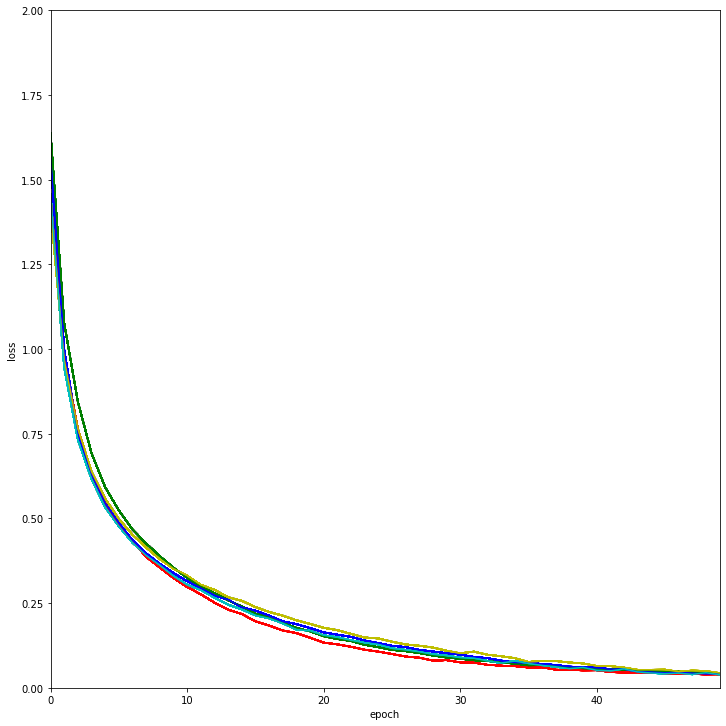

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(xlim=(0, 49), ylim=(0, 2))
plt.tight_layout()
line, = ax.plot([], [], lw=3)

 
def init():
    line.set_data([], [])
    return line,
def animate(i):
    for model in models:
        for color, alg in zip(['r', 'g', 'b', 'y', 'c', 'm'], algs):
            
            train = data[alg]['train']
            times = data[alg]['time']
            time = (i+3) * max_time / num_frames
            ax.plot(train[times<=time], label=alg, c=color)
            ax.set_xlabel('epoch')
            ax.set_ylabel('loss')

        
            
    
 
anim = FuncAnimation(fig, animate, frames=100, interval=500)


anim.save('train_gif.gif', writer='imagemagick')
 

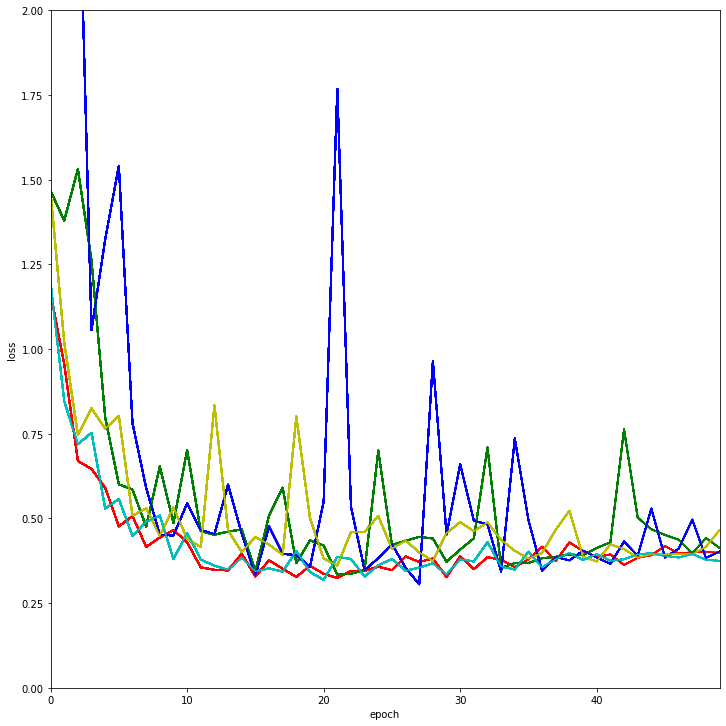

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(xlim=(0, 49), ylim=(0, 2))
plt.tight_layout()
line, = ax.plot([], [], lw=3)

 
def init():
    line.set_data([], [])
    return line,
def animate(i):
    for model in models:
        for color, alg in zip(['r', 'g', 'b', 'y', 'c', 'm'], algs):
            
            train = data[alg]['test']
            times = data[alg]['time']
            time = (i+3) * max_time / num_frames
            ax.plot(train[times<=time], label=alg, c=color)
            ax.set_xlabel('epoch')
            ax.set_ylabel('loss')
            

        
            
    
 
anim = FuncAnimation(fig, animate, frames=100, interval=500)


anim.save('test_gif.gif', writer='imagemagick')

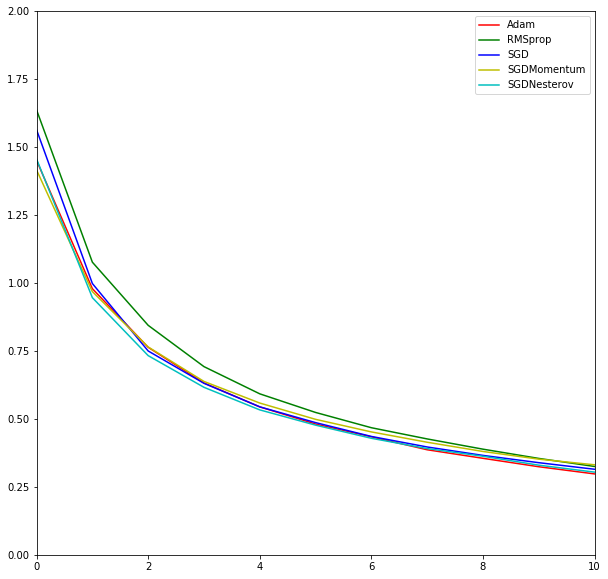

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(xlim=(0, 10), ylim=(0, 2))
for model in models:
    for color, alg in zip(['r', 'g', 'b', 'y', 'c', 'm'], algs):

        train = data[alg]['train']
        times = data[alg]['time']
        #time = i * max_time / num_frames
        ax.plot(train, label=alg, c=color)
ax.legend()
plt.show()
fig.savefig('legend_for_gif.png')